# Lab 3

**Lab Group** Group 4

**Lab Members**
* Ghaida Al-Atoum
* Wilma Davis
* Tango Tew

In [1]:
import os
import sys
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import tensorflow.keras
import tensorflow as tf
import scipy as sp
import tensorflow as tf
import platform
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
from PIL import Image
import cv2
from tensorflow.keras import models
import random as rand
import pandas as pd
import glob
from numpy import linalg as LA
from operator import itemgetter
import matplotlib.gridspec as gridspec


In [3]:
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")

Python Platform: Linux-5.19.0-45-generic-x86_64-with-glibc2.31
Tensor Flow Version: 2.9.2
Keras Version: 2.9.0

Python 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [7]:
# tf.debugging.set_log_device_placement(False)
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    # logical_gpus = tf.config.list_logical_devices('GPU')
    # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

In [8]:
gpus = tf.config.list_physical_devices('GPU')
print("GPU Resources Available:\n\t",gpus)

# getting rid of the warning messages about optimizer graph
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

GPU Resources Available:
	 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Helper Functions

In [9]:
def load_image_as_array(url, size=(150, 150), local_path=False):
    img = None
    if local_path:
        img = Image.open(url)
    else:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
    img = img.resize(size)
    return np.array(img).astype(float)

In [10]:
def prepare_image_for_display(img, norm_type='max'):
    if norm_type == 'max':
        # min/max scaling, best for regular images
        new_img = (img - img.min()) / (img.max()-img.min())
    else:
        # std scaling, best when we are unsure about large outliers
        new_img = ((img - img.mean()) / (img.std() +1e-3))*0.15 + 0.5
        
    new_img *= 255
    new_img = np.clip(new_img, 0, 255)
    
    if len(new_img.shape)>3:
        new_img = np.squeeze(new_img)
        
    return new_img.astype('uint8')

# Convolutional Neural Network Selected

**Model Chosen** <font color="blue">VGG19</font>

**Explain the model**
[The following Information Source](https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/)

* High Overview: VGG stands for Visual Geometry Group; it is a standard deep Convolutional Neural Network (CNN) architecture with multiple layers. The “deep” refers to the number of layers with VGG-16 or VGG-19 consisting of 16 and 19 convolutional layers.
* VGGNets are based on the most essential features of convolutional neural networks (CNN)
* The VGG network is constructed with very small convolutional filters (3x3). The VGG-19 consists of 16 convolutional layers and three fully connected layers.
* Convolutional Layers: VGG’s convolutional layers leverage a minimal receptive field, i.e., 3×3, the smallest possible size that still captures up/down and left/right. Moreover, there are also 1×1 convolution filters acting as a linear transformation of the input. This is followed by a ReLU unit, which is a huge innovation from AlexNet that reduces training time. ReLU stands for rectified linear unit activation function; it is a piecewise linear function that will output the input if positive; otherwise, the output is zero. The convolution stride is fixed at 1 pixel to keep the spatial resolution preserved after convolution (stride is the number of pixel shifts over the input matrix).


**Why was VGG19 Chosen**

* Simpler Architecture: VGG19's stacked convolutional layers offer a more straightforward but in-depth feature extractions and information flow compared to Inception-v3's inception modules and ResNet's in-depth and complex residual connections. This makes it easier to trace enough feature activations through the network while maintaining architectural simplicity, aiding interpretability of how the model interprete the image.
* Gradual Feature Extraction: VGG19 progressively increases the complexity of features layer by layer. This is beneficial for circuit analysis, where understanding the building blocks of feature extraction (from edges to shapes to components) might be important.

In [11]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions

## Classify few images with the pre-trained network

In [12]:
vgg19_classify_model = VGG19(weights='imagenet')

574710816/574710816 [==============================] - 11s 0us/step


In [13]:
# set VGG to be frozen
for layer in vgg19_classify_model.layers:
    layer.trainable = False
    
vgg19_classify_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
labels_df = pd.read_csv('classes_in_imagenet_2.txt', delim_whitespace=True)

In [201]:
def predict_images(folder, model, decorder, processor, size=(224,224)):
    for image_path in os.listdir(folder):
        path = os.path.join(folder, image_path)
        img = load_image_as_array(path, size=size, local_path=True)
        x = np.expand_dims(img, axis=0)

        preds = model.predict(x)
        top3_decoded_predictions = decorder(preds, top=3)[0]
        print('Predicted:', top3_decoded_predictions)

        # We add a dimension to transform our array into a "batch"
        # of size (1, 224, 224, 3)
        plt.figure(figsize=(10,5))
        plt.subplot(1,3,1)
        plt.imshow(prepare_image_for_display(x))
        plt.title('Image before processing', fontsize=8)

        # Finally we preprocess the batch
        # (this normalizes according to VGG training)
        x = processor(x)

        plt.subplot(1,3,2)
        plt.imshow(prepare_image_for_display(x))
        plt.title('Image after VGG pre-processing', fontsize=8)


        plt.subplot(1,3,3)
        plt.bar(*zip(*[x[1:] for x in top3_decoded_predictions]))
        plt.title('Top 3 Predictions for {}'.format(image_path), fontsize=8)

        plt.show()

1/1 [==============================] - 0s 18ms/step
Predicted: [('n02484975', 'guenon', 0.4414819), ('n02487347', 'macaque', 0.37712857), ('n02488291', 'langur', 0.071191594)]


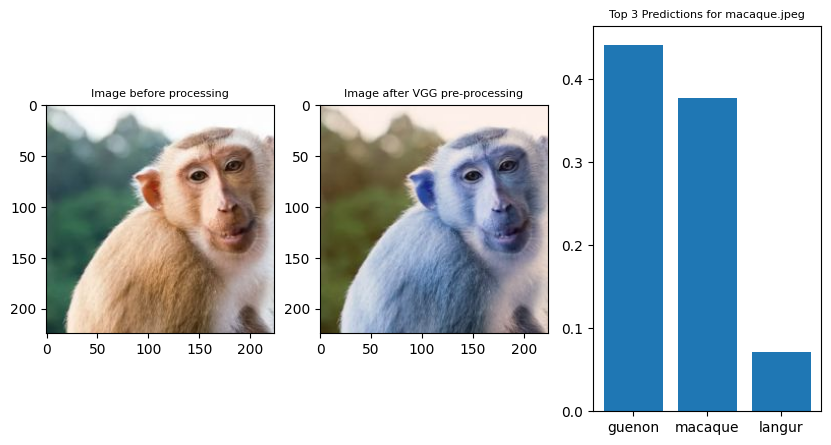

1/1 [==============================] - 0s 17ms/step
Predicted: [('n02105412', 'kelpie', 0.752319), ('n02093256', 'Staffordshire_bullterrier', 0.045472696), ('n02109961', 'Eskimo_dog', 0.040999122)]


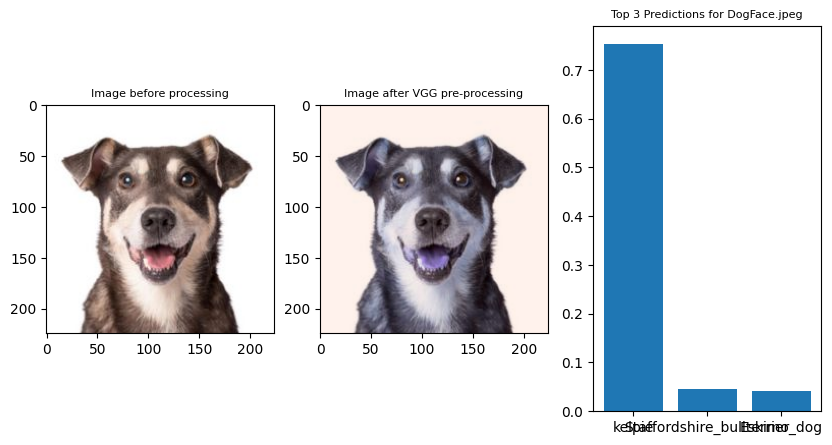

In [229]:
predict_images("/notebooks/Lab3/test_images",vgg19_classify_model, decode_predictions, preprocess_input)

**Notes**

# Select a Multi-Channel Filter in a layer to analyze as part of a circuit

In [17]:
layer_name = 'block4_conv3'
previous_layer_name = 'block4_conv2'
filter_index = 67 

## Find an input image that maximally excites the chosen multi-channel filter

In [18]:
# Load the pre-trained VGG16 model
vgg19_model = VGG19(weights='imagenet', include_top=False, input_tensor=None)

# set VGG to be frozen
for layer in vgg19_model.layers:
    layer.trainable = False


80134624/80134624 [==============================] - 1s 0us/step


In [20]:
def print_layer_filter_info(model, layer_name, filter_index):
    keras_layer = model.get_layer(layer_name)
    layer_output = keras_layer.output
    weights_list = keras_layer.get_weights() # list of filter, the biases
    filters = weights_list[0]
    biases = weights_list[1]

    # print out some specifics of how the filter is saved
    print('{} activation size is '.format(layer_name), layer_output.get_shape(), '(batch x H x W x filter)')
    print('{} filters is of shape'.format(layer_name),filters.shape, '...(k x k x channels x filters)')
    print('{} biases is of shape'.format(layer_name),biases.shape)

    idx = 67
    print('one filter in {} is '.format(layer_name), filters[:,:,:,idx].shape )
    channel = 2
    print('one channel in the the filter is', filters[:,:,channel,idx].shape)
    print('The weights of that channel in the filter are:\n', filters[:,:,channel,idx])
    print('The bias of the filter is:',biases[idx])

In [21]:
print_layer_filter_info(vgg19_model, 'block2_conv2', 127)

block2_conv2 activation size is  (None, None, None, 128) (batch x H x W x filter)
block2_conv2 filters is of shape (3, 3, 128, 128) ...(k x k x channels x filters)
block2_conv2 biases is of shape (128,)
one filter in block2_conv2 is  (3, 3, 128)
one channel in the the filter is (3, 3)
The weights of that channel in the filter are:
 [[ 0.01507936  0.01508568 -0.00442873]
 [ 0.01061279  0.00204056 -0.00726704]
 [ 0.0145152   0.00187207 -0.00568341]]
The bias of the filter is: 0.02079411


In [22]:
def generate_pattern(model, processor, layer_name, filter_index, size=224, epochs=40):
    # Build a model that outputs the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    # Isolate the output 
    new_model = models.Model(inputs=model.input, outputs=layer_output)
    # We start from a gray image with some uniform noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    I_start = tf.Variable(input_img_data, name='image_var', dtype = 'float64')
    I = processor(I_start) # only process once
    # Run gradient ascent for 40 steps
    eta = 1.
    for i in range(epochs):
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(I)
            # get variable to maximize 
            model_vals = new_model(I) 
            filter_output = tf.reduce_mean(model_vals[:, :, :, filter_index])

        # Compute the gradient of the input picture w.r.t. this loss
        # add this operation input to maximize
        grad_fn = tape.gradient(filter_output, I)
        # Normalization trick: we normalize the gradient
        grad_fn /= (tf.sqrt(tf.reduce_mean(tf.square(grad_fn))) + 1e-5) # mean L2 norm
        I += grad_fn * eta # one iteration of maximizing
        
    # return the numpy matrix so we can visualize 
    img = I.numpy()
    return prepare_image_for_display(img, norm_type='std')

In [23]:
pattern_generated_main = generate_pattern(
    model = vgg19_model,
    processor = preprocess_input,
    layer_name = layer_name,
    filter_index = filter_index,
    epochs=100
)

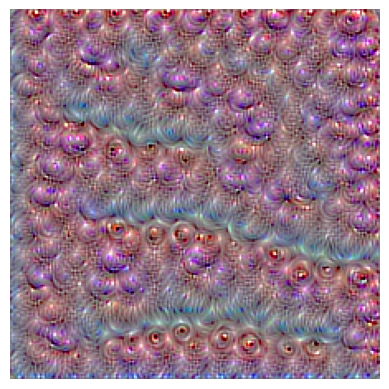

<Figure size 640x480 with 0 Axes>

In [24]:
fig = plt.imshow(pattern_generated_main)
plt.axis('off')
plt.show()
plt.savefig('pattern_{}'.format(layer_name))

## Send Images of Varying Classes and track which most excites the chosen filter


* [Data Source](https://www.image-net.org/download.php)
* [Data Source Kaggle](https://www.kaggle.com/competitions/imagenet-object-localization-challenge/data)

In [25]:
train_dir = "/notebooks/Lab3/image_net_5_per_class"
train_files = [i for i in glob.glob(train_dir + "//*//*")]
rand.shuffle(train_files)

train_labels = [
    os.path.dirname(i).split("/")[-1] for i in train_files
]

train_df = pd.DataFrame(data = {"file_path": train_files, "classification": train_labels})
print("Training data description: \n{}".format(train_df.describe()))

Training data description: 
                                                file_path classification
count                                                5000           5000
unique                                               5000           1000
top     /notebooks/Lab3/image_net_5_per_class/n0771457...      n07714571
freq                                                    1              5


In [26]:
def get_out_per_class(dataset, model, processor, layer_name, filter_index,  samp_num=2, size=(224,224)):
    # Build a model that outputs the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    # Isolate the output 
    new_model = models.Model(inputs=model.input, outputs=layer_output)
    
    # We start from a gray image with some uniform noise
    # input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    res = {}
    res['class'] = []
    res['result'] = []
    res['label'] = []
    for class_type in train_df['classification'].unique():
        
        image_paths = train_df.loc[train_df['classification'] == class_type]['file_path'].sample(n=samp_num)
        filter_outputs = np.empty(samp_num)
        for idx, image_path in enumerate(image_paths):
            img = load_image_as_array(image_path, size=size, local_path=True)
            x = np.expand_dims(img, axis=0)
            I_start = tf.Variable(x , name='image_var', dtype = 'float64')
            I = processor(I_start) # only process once
            model_vals = new_model(I) 
            filter_output = tf.reduce_mean(model_vals[:, :, :, filter_index])
            filter_outputs[idx] = filter_output.numpy()
        res['class'].append(class_type)
        res['label'].append(labels_df.loc[labels_df['class'] == class_type].label.item())
        res['result'].append(np.mean(filter_outputs))
    return pd.DataFrame(res)

In [27]:
%%time
result = get_out_per_class(
    dataset = train_df,
    model = vgg19_model,
    processor = preprocess_input,
    layer_name = layer_name,
    filter_index = filter_index
)

CPU times: user 24 s, sys: 2.99 s, total: 27 s
Wall time: 43.7 s


In [226]:
print(result.nlargest(30, 'result')['label'].tolist())

['gyromitra', 'buckeye', 'grocery_store', 'tailed_frog', 'chiton', 'rock_crab', 'affenpinscher', 'gorilla', 'Appenzeller', 'Dutch_oven', 'keeshond', 'Irish_setter', 'boxer', 'guinea_pig', 'tiger_beetle', 'night_snake', 'mud_turtle', 'Tibetan_mastiff', 'Rottweiler', 'whiptail', 'kit_fox', 'briard', 'otterhound', 'miniature_poodle', 'marmot', 'langur', 'common_newt', 'cabbage_butterfly', 'rock_python', 'baboon']


Text(0, 0.5, 'mean output')

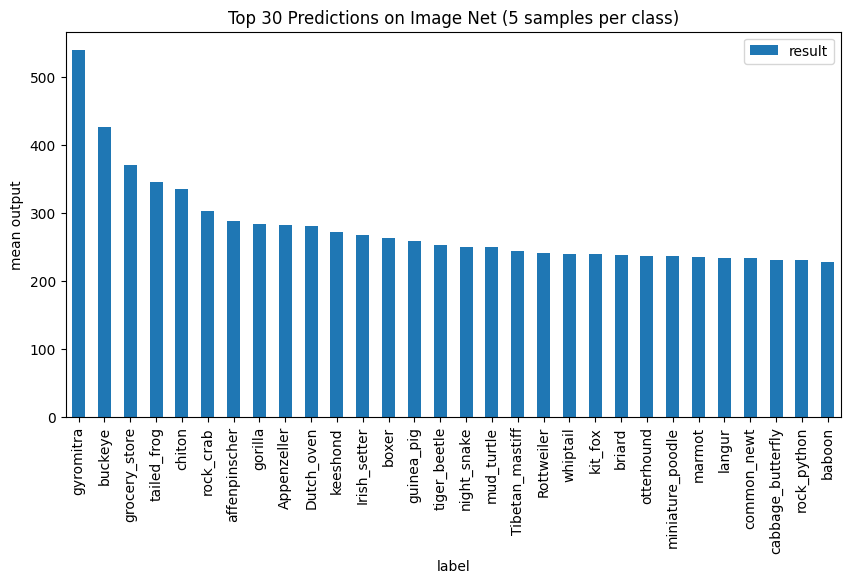

In [220]:
result.nlargest(30, 'result').plot('label','result', kind='bar', figsize=(10,5), title='Top 30 Predictions on Image Net (5 samples per class)')
plt.xlabel('label')
plt.ylabel('mean output')

## Hypothesis for What the chosen filter might be extracting

['gyromitra', 'buckeye', 'grocery_store', **'tailed_frog'**, 'chiton', **'rock_crab'**, **'affenpinscher'**, **'gorilla'**, 'Appenzeller', 'Dutch_oven', **'keeshond'**, **'Irish_setter'**, **'boxer'**, **'guinea_pig'**, **'tiger_beetle'**, **'night_snake'**, **'mud_turtle'**, **'Tibetan_mastiff'**, **'Rottweiler'**, **'whiptail'**, **'kit_fox'**, **'briard'**, '**otterhound'**, **'miniature_poodle'**, **'marmot'**, **'langur'**, **'common_newt'**, 'cabbage_butterfly', **'rock_python'**, **'baboon'**]

Sending images of varying classes from ImageNet through the network up until the selected layer/filter. Looking at the top 30 of mostly excited images, we  observe that a lot of those classes included an animal with pose invariant features.

For the selected **Filter67 from Block4_Conv3** we hypothesize that it is **maximally excited by a pose invariant head feature.**

Thus labeling this filter as a possible pose invariant head detector.


# Analyzing Each Channel of the multi-channel filter - How it might form a circuit ?

In [115]:
def excitory_inhabotiry(layer_coef, filter_index, channel=None):
    f_min, f_max = layer_coef.min(), layer_coef.max()
    temp = (layer_coef - f_min) / (f_max - f_min)
    filters_norm = None
    if channel == None:
        filters_norm = LA.norm(temp[:,:,:,filter_index])
    else:
        filters_norm = LA.norm(temp[:,:,channel,filter_index])
    mean_v = np.mean(filters_norm)
    if mean_v < 0.5:
        return "Inhibitory", mean_v
    else:
        return "Excitatory", mean_v

In [29]:
base_filters, _ = vgg19_model.get_layer(layer_name).get_weights()

## Finding the top 10 Filter of the previous Layer 

**Previous Layer: block4_conv2**

In [94]:
filters, _ = vgg19_model.get_layer(previous_layer_name).get_weights()
x = {}
for filterNum in range(filters.shape[3]):
    x[filterNum] = LA.norm(filters[:,:,:,filterNum])
top_filters = dict(sorted(x.items(), key=itemgetter(1), reverse=True)[:10])

## Finding the top 3 channels for each of the top filters of the previous layer

In [31]:
top_channels_per_filter = {}
for top_filter in top_filters:
    y = {}
    for channel in range(filters.shape[2]):
        y[channel] = LA.norm(filters[:,:,channel,top_filter])
    top_channels = dict(sorted(y.items(), key=itemgetter(1), reverse=True)[:3]).keys()
    top_channels_per_filter[top_filter] = top_channels

In [230]:
# https://distill.pub/2020/circuits/visualizing-weights/
H = lambda S : int(S, 16)/255.
C = lambda X: np.asarray([H(X[0:2]), H(X[2:4]), H(X[4:6])])

def weight_color_scale(x):
    threshold=0.1
    if x < 0:
        x = -x
        if x < threshold:
            x = x*2
            return (1-x)*C("f7f7f7") + x*C("1a1aff")
        else:
            x = (x-threshold)*2
            return (1-x)*C("1a1aff") + x*C("000033")
    else:
        if x < threshold:
            x = x*2
            return (1-x)*C("f7f7f7") + x*C("b30000")
        else:
            x = (x-threshold)*2
            return (1-x)*C("b30000") + x*C("1a0000")

weight_heatmap = lambda X: np.asarray([[weight_color_scale(x) for x in X_] for X_ in X])

In [214]:
def plot_relation_filters(top_filter, top_channels_per_filter_dict, prev_layer_filters, f_idx_under_examine, base_filters):
    # Visualize Top Channels per filter to the filter under study
    fig = plt.figure(figsize=(10,10))
    gs0 = gridspec.GridSpec(1, 3, figure=fig, hspace=0.0,wspace=0.1)
    gs00 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0], hspace=0.4,wspace=0.1)
    for c_idx, top_channel in enumerate(top_channels_per_filter_dict[top_filter]):
        im = weight_heatmap(prev_layer_filters[:,:,top_channel,top_filter])
        ax = fig.add_subplot(gs00[c_idx])
        if (c_idx == 0):
            t = ax
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
        ei, m = excitory_inhabotiry(layer_coef=prev_layer_filters, filter_index=top_filter, channel=top_channel)
        ax.set_title('L[{}]F[{}]Ch:[{}]\nType[{}/{:5.4f}]'.format(previous_layer_name, top_filter, top_channel, ei, m))
        ax.title.set_size(9)
        for i in range(prev_layer_filters[:,:,top_channel,top_filter].shape[0]):
            for j in range(prev_layer_filters[:,:,top_channel,top_filter].shape[1]):
                c = prev_layer_filters[i,j,top_channel,top_filter]
                ax.text(i, j, str(c), va='center', ha='center', size = 6)

    gs01 = gs0[1].subgridspec(1, 1)

    axs = fig.add_subplot(gs01[-1, -1])
    im_pattern = generate_pattern(
        model = vgg19_model,
        processor = preprocess_input,
        layer_name = previous_layer_name,
        filter_index = top_filter,
        epochs=40
    )

    axs.imshow(im_pattern)
    axs.set_xticks([])
    axs.set_yticks([])
    _, m = excitory_inhabotiry(prev_layer_filters, top_filter)
    axs.set_title('L[{}]F[{}]Avg[{:5.4f}]'.format(previous_layer_name, top_filter,m ))
    axs.title.set_size(8)
    d = axs

    gs02 = gs0[2].subgridspec(1, 1)

    axs = fig.add_subplot(gs02[-1, -1])
    axs.imshow(pattern_generated_main)
    axs.set_xticks([])
    axs.set_yticks([])
    _, m = excitory_inhabotiry(base_filters, f_idx_under_examine)
    axs.set_title('L[{}]F[{}]Avg[{:5.4f}]'.format(layer_name, filter_index,m))
    axs.title.set_size(8)

# Results

* Plotting of the input activations (previous layer) :
    * Plotting its 10 top filters patterns
    * For each of those patterns visualize the coefficients of their top 3 channels 
    * Describing the filter properties
* Describing the properties of the circuit and relating it back to the hypothesis of the pose invariant head detector

**The following code visually explains what is being plotted for each one of the top filter results**

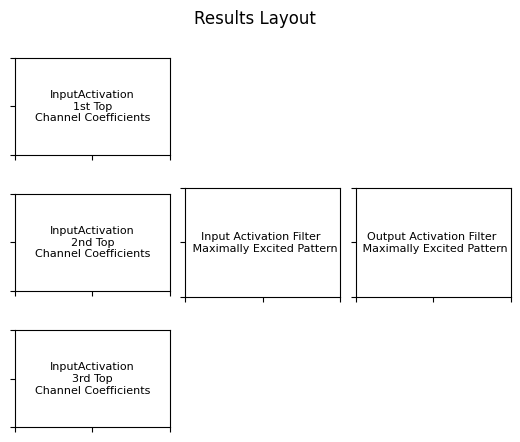

In [276]:
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_nested.html#sphx-glr-gallery-subplots-axes-and-figures-gridspec-nested-py
fig = plt.figure()
gs0 = gridspec.GridSpec(1, 3, figure=fig, hspace=0.0,wspace=0.1)
gs00 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs0[0], hspace=0.4,wspace=0.1)

ax1 = fig.add_subplot(gs00[0])
ax1.text(0.5, 0.5, "InputActivation\n1st Top\nChannel Coefficients" , va="center", ha="center", size=8, clip_on=True)
ax1.tick_params(labelbottom=False, labelleft=False)

ax2 = fig.add_subplot(gs00[1])
ax2.text(0.5, 0.5, "InputActivation\n2nd Top\nChannel Coefficients" , va="center", ha="center", size=8, clip_on=True)
ax2.tick_params(labelbottom=False, labelleft=False)

ax3 = fig.add_subplot(gs00[2])
ax3.text(0.5, 0.5, "InputActivation\n3rd Top\nChannel Coefficients" , va="center", ha="center", size=8, clip_on=True)
ax3.tick_params(labelbottom=False, labelleft=False)

gs01 = gs0[1].subgridspec(3,1)

ax4 = fig.add_subplot(gs01[1])
ax4.text(0.5, 0.5, "Input Activation Filter \n Maximally Excited Pattern" , va="center", ha="center", size=8, clip_on=True)
ax4.tick_params(labelbottom=False, labelleft=False)

gs01 = gs0[2].subgridspec(3, 1)

ax5 = fig.add_subplot(gs01[1])
ax5.text(0.5, 0.5, "Output Activation Filter \n Maximally Excited Pattern" , va="center", ha="center", size=8, clip_on=True)
ax5.tick_params(labelbottom=False, labelleft=False)

plt.suptitle("Results Layout")

plt.show()

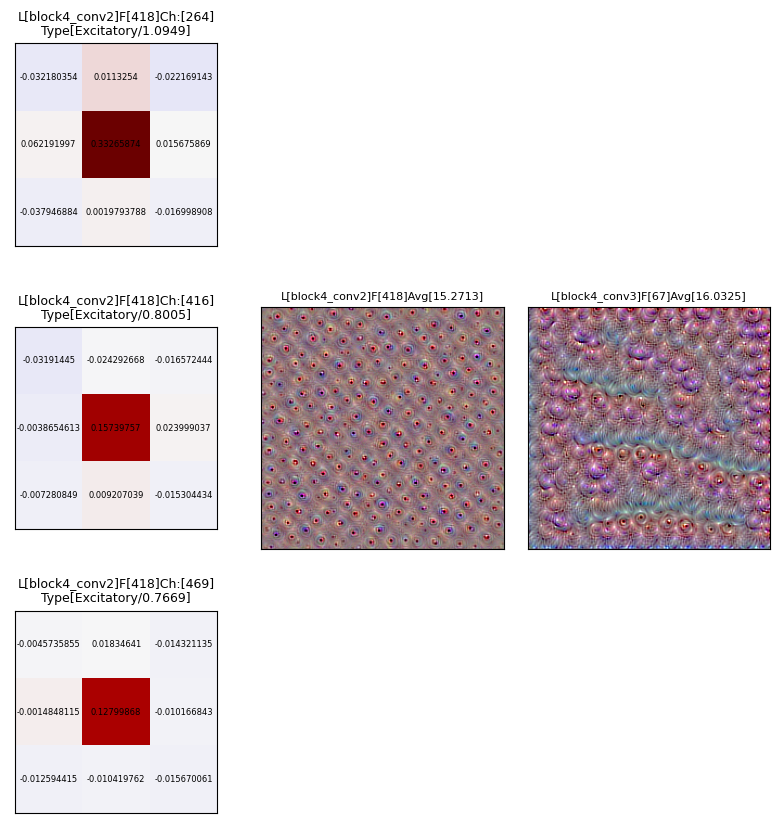

In [215]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[0],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)

<font size="4" color='blue'>
    <font size="5">Previous Layer: block4_conv2 - Top Filter: Filter 418<br></font>
    <b>Circular detector:</b>
    <ul>
      <li>The activation map for this particular filter (Filter 418) exhibits strong excitatory responses to central circular patterns, as evidenced by the pronounced activation in the center of the feature map(as we can see the center of the kernel sharpened). Simultaneously, there is a notable inhibitory response towards the periphery of the receptive field(all the edges (top, left and bottom) of the kernel).</li>
      <li>Which is evidence that it was probably extensively contributing to the eyes structure of the pose face invariant</li>
    </ul>
</font>

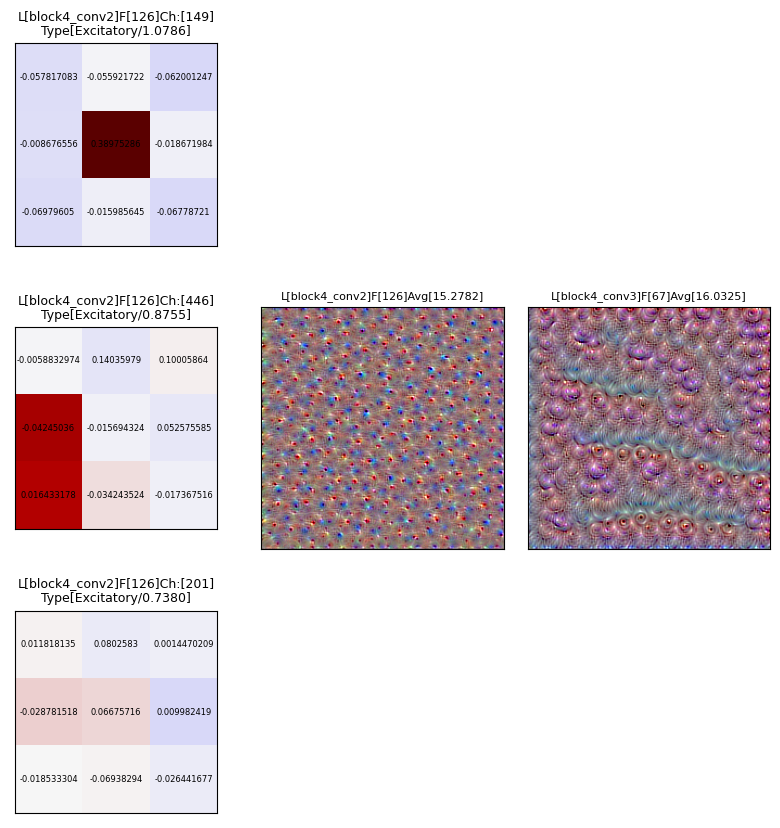

In [181]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[1],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)


<font font size="4" color='blue'>
    <font size="5">Previous Layer: block4_conv2 - Top Filter: Filter 126<br></font>
    <b>Hues(Color) Detector:</b> <br>Detecting redness circular objects in the image. The strongest channel is 3x3 kernel in which it excites the middle
    <ul>
      <li>This activation map exhibits strong excitatory response to the color-detection unit, optimized for identifying red circular areas within the visual field. The activation pattern indicates a maximal excitatory response from the center and the bottom left of kernel, which suggests that this neuron-like element acts as a focal detector with heightened sensitivity to red hues localized at the center of its feature map.</li>
      <li>Which is evidence that it was probably extensively contributing to lighting  on the left side of the pose face invariant structure.</li>
    </ul>
</font>

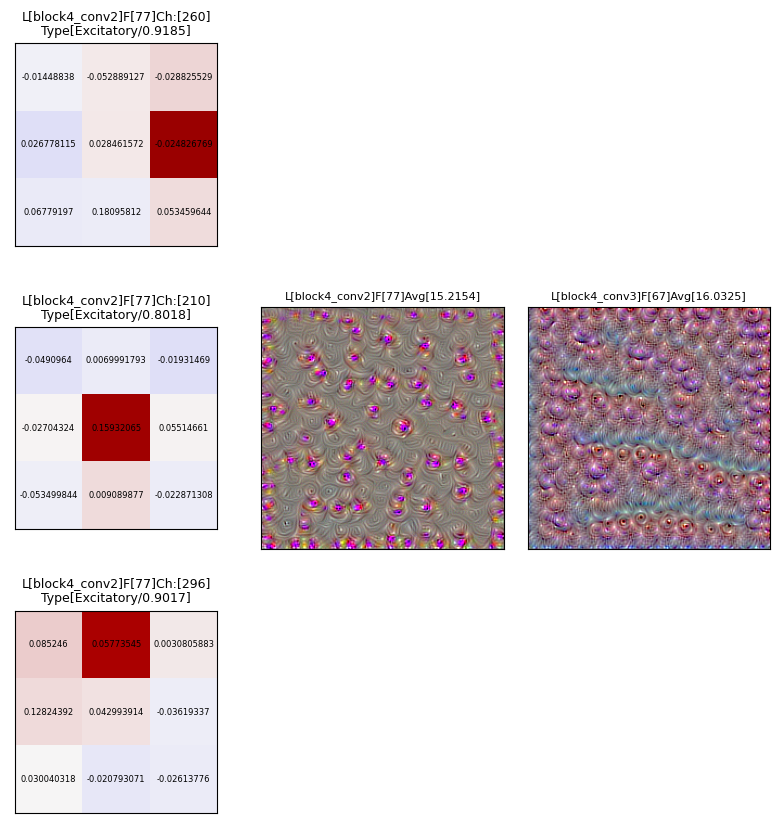

In [182]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[2],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)

<font font size="4" color='blue'>
    <font size="5">Previous Layer: block4_conv2 - Top Filter: Filter 77<br></font>
    <b>Hues(Circular color) Detector:</b>
    <ul>
      <li>This activation map exhibits color-detection unit mostly identifying reddish or pink circular areas within the visual field. The activation pattern indicates a maximal excitatory response from the center, middle right and the middle top of the kernel, which suggests that this neuron-like element acts as a focal detector with heightened sensitivity to colored circular areas localized at the center of its feature map.</li>
      <li>This is an evidence that its representing the color contrast of the pose face invariant features, such as the eyes, nose or tongue, etc.</li>
    </ul>
</font>

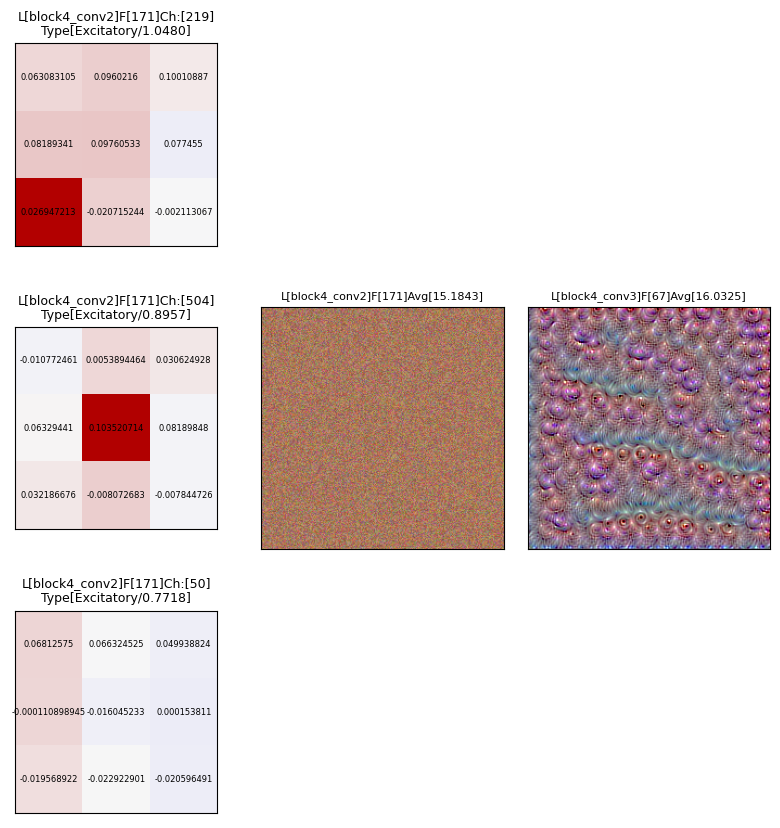

In [183]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[3],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)

<font font size="4" color='blue'>
    <font size="5">Previous Layer: block4_conv2 - Top Filter: Filter 171<br></font>
    <b>Texture Detector:</b>
    <ul>
      <li>This activation map displays a minimal texture detection(smoothed out through the visual display), showing strong excitement on the bottom left and middle of two of the kernels, which means that It might not be contributing much to the feature detections but to the texture detection.</li>
      <li>This is an evidence that it might be the frame of the pose face invariant.</li>
    </ul>
</font>

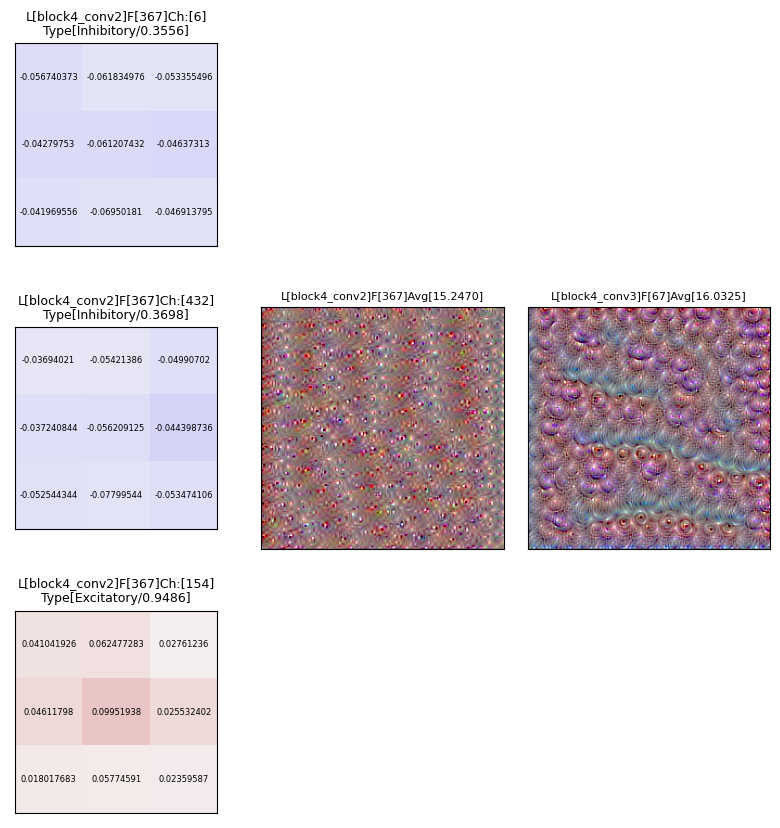

In [184]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[4],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)

<font font size="4" color='blue'>
    <font size="5">Previous Layer: block4_conv2 - Top Filter: Filter 367<br></font>
    <b>High-Low Frequency Detectors:</b>
    <ul>
      <li>This activation map reveals a high-low frequency sensitivity within the activation features.</li>
      <li>This is an evidence that it’s detecting the boundaries of the object within the pose face invariant detection.</li>
    </ul>
</font>

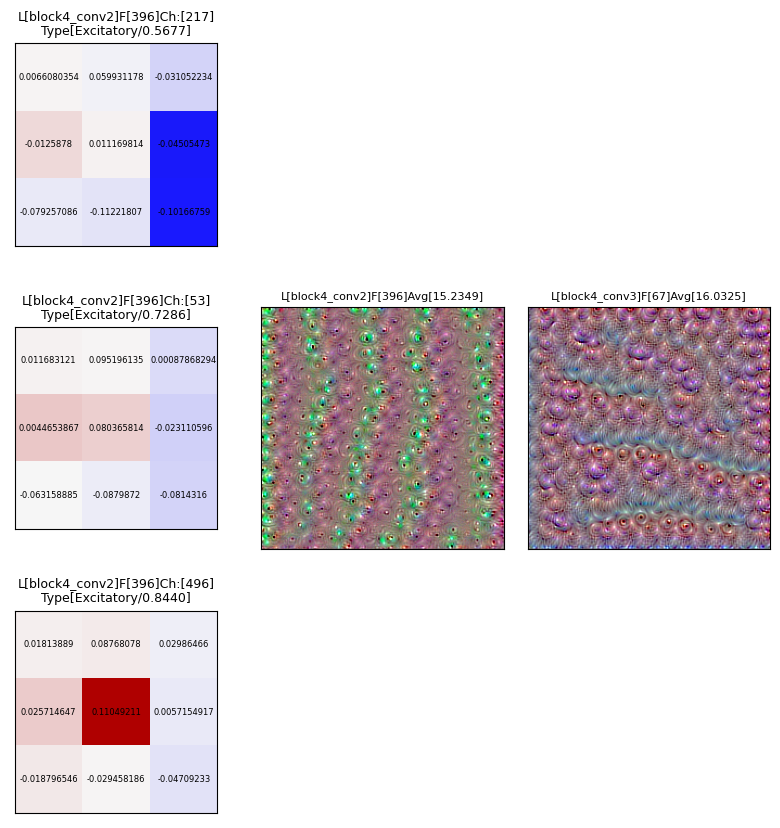

In [185]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[5],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)

<font font size="4" color='blue'>
    <font size="5">Previous Layer: block4_conv2 - Top Filter: Filter 396<br></font>
    <b>Hues(Circular color) Detector:</b>
    <ul>
      <li>This activation map exhibits color-detection unit mostly identifying yellowish or greenish circular areas within the visual field. The activation pattern indicates a maximal excitatory response from the center, middle left, which suggests that this neuron-like element acts as a focal detector with heightened sensitivity to colored circular areas localized at the center/left of its feature map. In addition, the filter exhibits an inhibitory behavior on the right vertical.</li>
      <li>This is an evidence that its representing the color contrast of the pose face invariant features, such as the eyes, nose or tongue, etc.
</li>
    </ul>
</font>

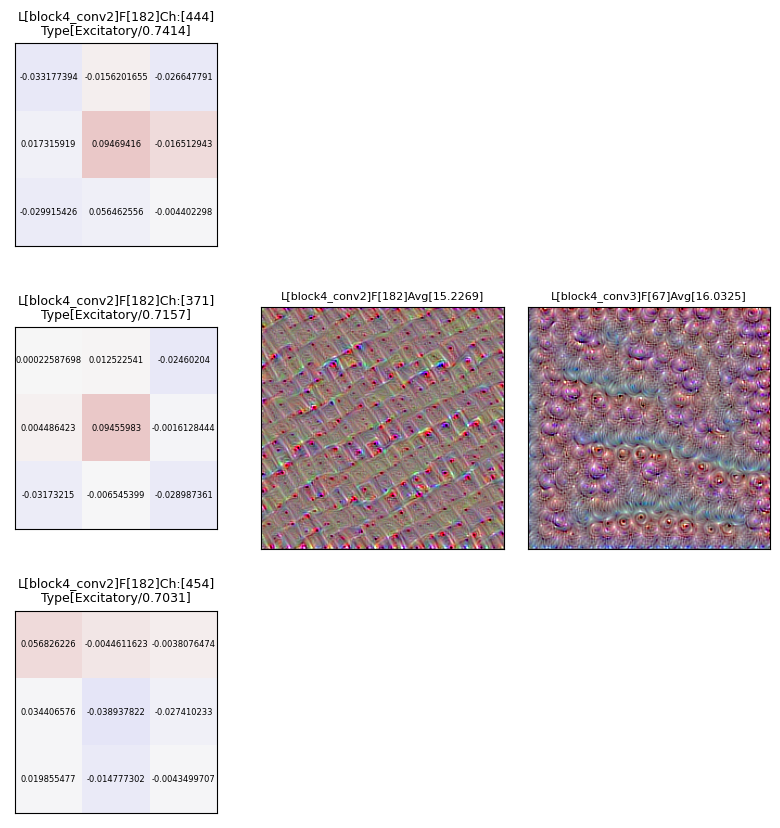

In [186]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[6],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)

<font font size="4" color='blue'>
    <font size="5">Previous Layer: block4_conv2 - Top Filter: Filter 182<br></font>
    <b>Line Detector:</b>
    <ul>
      <li>This activation map exhibits a line detection unit mostly identifying line patterns regardless of orientation within the visual field. The activation pattern indicates a maximal excitatory response along the horizontal edge,  middle, which suggests that this neuron-like element acts as a focal detector with heightened sensitivity to line patterns in the feature map.</li>
      <li>This is an evidence that its represents boundary detection for  the pose invariant head features.</li>
    </ul>
</font>

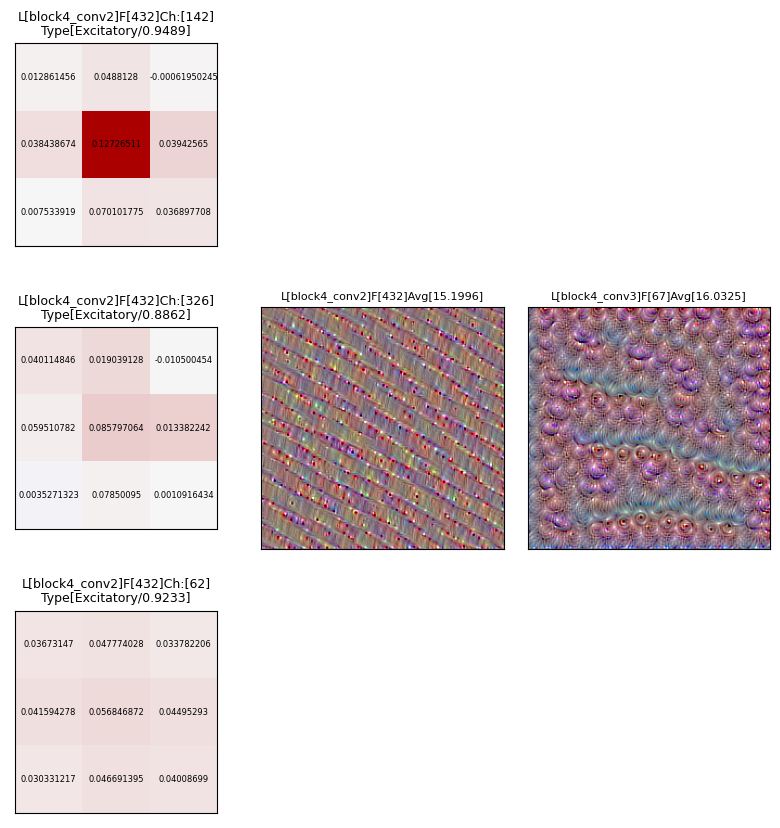

In [187]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[7],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)

<font font size="4" color='blue'>
    <font size="5">Previous Layer: block4_conv2 - Top Filter: Filter 432<br></font>
    <b>Line Detector:</b>
    <ul>
      <li>This activation map exhibits a line detection unit mostly identifying line patterns regardless of orientation within the visual field. The activation pattern indicates a maximal excitatory response along all edges horizontal, vertical, and diagonal. That suggests that this neuron-like element acts as a focal detector with heightened sensitivity to line patterns in the feature map. </li>
      <li>Comparing to the pervious investigated filter #182 this line detector seems to be more highly defined.</li>
      <li>This is an evidence that its represents boundary detection for  the pose invariant head features.</li>
    </ul>
</font>

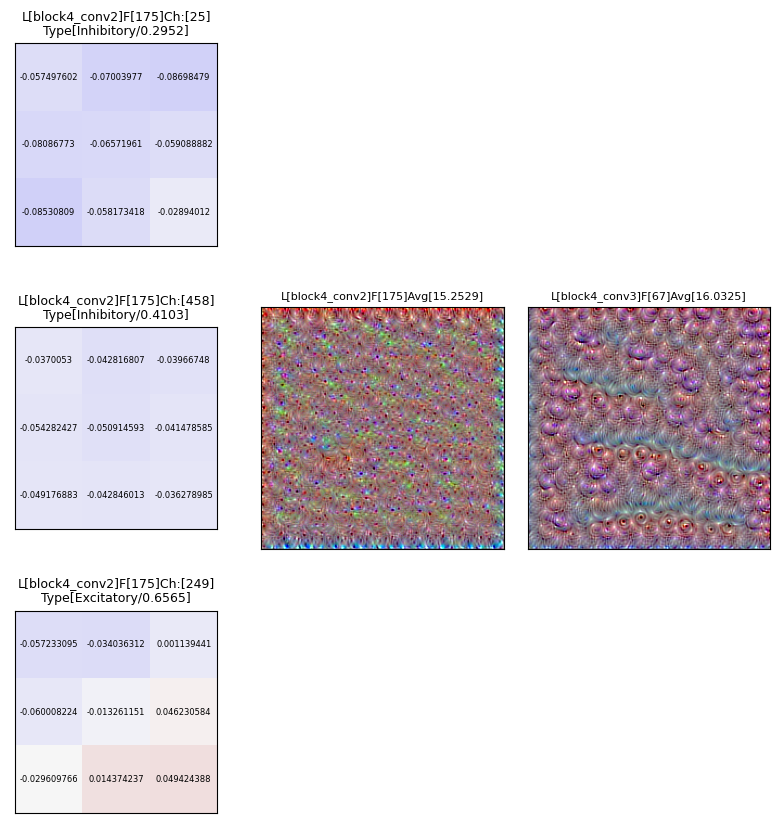

In [188]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[8],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)

<font font size="4" color='blue'>
    <font size="5">Previous Layer: block4_conv2 - Top Filter: Filter 175<br></font>
    <b>High Contrast Color Detector:</b>
    <ul>
      <li>This activation map exhibits a high color contrast detection unit mostly identifying highly contrasted colors appearing next to each other within the visual field. The activation pattern indicates a general maximal inhibitory response. Looking at the maximally excited pattern of this filter we can see the top/left are highly contrasted to the bottom/right.  </li>
      <li>This is evidence that it represents boundary detection for  the pose invariant features. Such as eyes to head, pose to surroundings . 
</li>
    </ul>
</font>

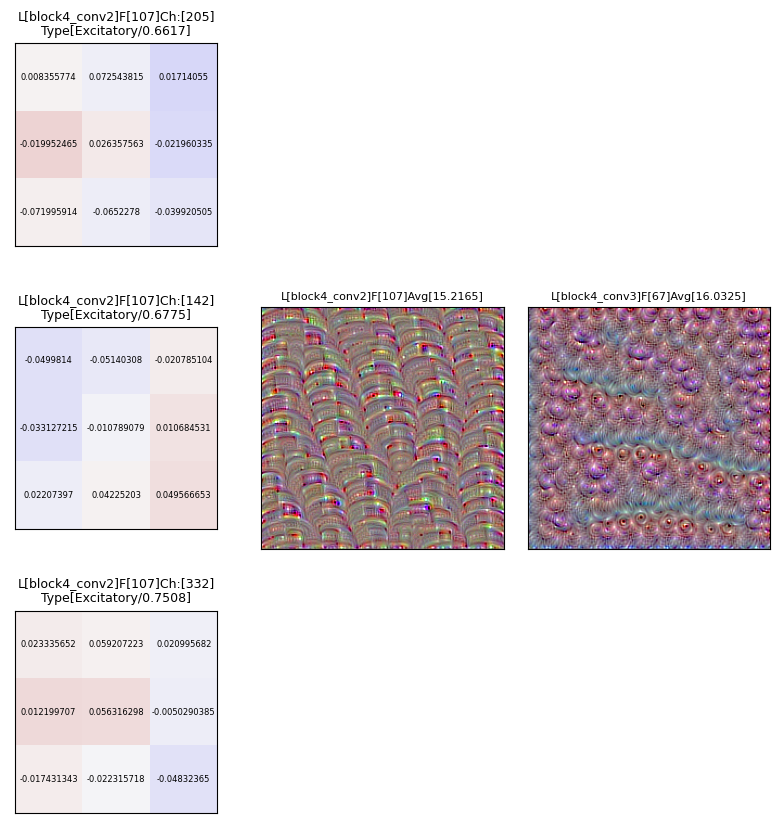

In [189]:
plot_relation_filters(
    top_filter = list(top_filters.keys())[9],
    top_channels_per_filter_dict = top_channels_per_filter,
    prev_layer_filters = filters,
    f_idx_under_examine = filter_index,
    base_filters = base_filters
)

<font font size="4" color='blue'>
    <font size="5">Previous Layer: block4_conv2 - Top Filter: Filter 107<br></font>
    <b>Curve Detector:</b>
    <ul>
      <li>This activation map exhibits a curve detector unit within the visual field. Given we are only looking at the top 3 channels the activation pattern doesn’t necessarily follow a visible curve. However, the generated pattern for that filter clearly shows the curve pattern. </li>
      <li>This is evidence that it represents pose invariant head features. Such as the head, eyebrows, eyes, and general facial features.</li>
    </ul>
</font>